<div style="direction:rtl;line-height:300%;">
<font face="XB Zar" size=5>
<div align=center>
<font face="B Titr" size=5>
<p></p><p></p>
بسمه تعالی
<p></p>
</font>
<p></p>
<font>
<br>
درس بازیابی پیشرفته اطلاعات
<br>
مدرس: دکتر بیگی
</font>
<p></p>
<br>
<font>
<b>تمرین سوم</b>
</font>
<br>
<br>
موعد تحویل: ۴ دی <br>
<br>
<br>
<br>
<font>
دانشگاه صنعتی شریف
<br>
دانشکده مهندسی کامپیوتر
<br>
<br>
</font>
</div>
</font>
</div>

<span style="color: red;">
<div dir='rtl'>

<b> نام و نام‌‌خانوادگی: </b>
Matin Moradi

<b> شماره دانشجویی: </b>
98104488

<b> لینک colab: </b>

<!-- UPLOAD YOUR NOTEBOOK TO GOOGLE COLAB AND MAKE SURE TO RUN ALL OF ITS CELLS -->
</div>
</span>

<div dir='rtl'>
<h1> 
مقدمه
</h1>
<p>
در این تمرین قصد داریم به مباحث زیر بپردازیم:
<li> embedding </li>
<li> کلاسه‌بندی متن </li>
<li> کاهش ابعاد </li>
<li> خوشه‌بندی متن و هرس‌کردن خوشه‌ها</li>

دیتاست این تمرین از دیتاست‌های kaggle انتخاب شده‌است و لینک آن در بخش اول تمرین در اختیار شما قرار داده شده است.

کتابخانه‌های مورد نظرتان را هم می‌توانید در اولین سل نوت‌بوک فراخوانی کنید. 
</p>
</div>

In [230]:
import opendatasets as od
import kaggle
import pandas as pd
import numpy as np
import string
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import fasttext
import sklearn

<div dir='rtl'>
<h1>1.
دریافت و آماده‌سازی دیتاست
</h1>
<p>
دیتاست استفاده شده در این تمرین، مجموعه‌ای عناوین، خلاصه، و ژانر چندین کتاب است. 
این دیتاست در kaggle موجود است. 
ابتدا این دیتاست را با استفاده از kaggle api دریافت کنید و سپس آن را لود کنید.
<br/>
لینک دیتاست: https://www.kaggle.com/datasets/athu1105/book-genre-prediction
<br>
<i>در صورتی که با خطای 443 مواجه شدید، یا از پراکسی استفاده کنید یا از کولب.</i>
</p>
</div>

In [231]:
# # TODO: Download Dataset (https://www.kaggle.com/datasets/athu1105/book-genre-prediction) Using Kaggle API

# dataset_url = 'https://www.kaggle.com/datasets/athu1105/book-genre-prediction'
# od.download(dataset_url)

In [232]:
# TODO: Load Dataset into df

df = pd.read_csv("./book-genre-prediction/data.csv")
df = df.sample(frac=1, random_state= 23).reset_index(drop=True)
print(df.head)

<bound method NDFrame.head of       index                           title     genre  \
0       911       The Man Who Fell to Earth   science   
1      1183          A Drink Before the War     crime   
2        33         Curse of the Mistwraith   fantasy   
3       354                       Elsewhere   fantasy   
4       322               Pools of Darkness   fantasy   
...     ...                             ...       ...   
4652   4426              The House of Hades   fantasy   
4653    466                   The Immortals   fantasy   
4654   3092  The Rise of Theodore Roosevelt   history   
4655   3772                 Without Remorse  thriller   
4656    860                 The Shadow Trap   science   

                                                summary  
0      Thomas Jerome Newton is a humanoid alien who ...  
1      Boston private detectives Patrick Kenzie and ...  
2      Born on a splinter world, Lysaer and Arithon ...  
3      Elsewhere tells the story of a fifteen year o.

In [233]:
# TODO: Perform data cleaning and eda (you can add cells here)

missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)
# df.dropna()

duplicates = df.duplicated()
for d in duplicates:
    if d is True:
        print("\nDuplicate Row:\n", d)
# df.drop_duplicates()

Missing Values:
 index      0
title      0
genre      0
summary    0
dtype: int64


<div dir='rtl'>
<p>
حال در این مرحله، به پیش‌پردازش متن می‌پردازیم. این پیش‌پردازش باید روی هر دو ستون title و summary اعمال شود.
برای پیش‌پردازش نیازی نیست که هرکدام از اعمال پیش‌پردازش را خودتان مانند تمارین قبل پیاده کنید. برای پیاده‌سازی تابع زیر می‌توانید از کتابخانه‌های معمول برای این کار بهره ببرید.
</p>
</div>

In [234]:
import spacy

nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [235]:
import re
import nltk
from nltk.corpus import stopwords
import string
  

def word_tokenizer(text):
    words = word_tokenize(text)
    return words

def remove_stopwords(words, stopwords_domain):
    stopwords_collection = stopwords.words('english')
    words = [word for word in words if (word not in stopwords_collection) and (word not in set(stopwords_domain)) ]
    return words

def remove_punctuations(words):
    punctuation_removed_words = [''.join([char for char in word if char not in string.punctuation]) for word in words]
    return punctuation_removed_words

def normalize(words):
    doc = nlp(' '.join(words))
    normalized_words = [token.lemma_ for token in doc]
    return normalized_words


In [236]:
def preprocess_text(text, minimum_length=1, stopword_removal=True, stopwords_domain=[], lower_case=True,
                       punctuation_removal=True):
    """
    preprocess text by removing stopwords, punctuations, and converting to lowercase, and also filter based on a min length
    for stopwords use nltk.corpus.stopwords.words('english')
    for punctuations use string.punctuation

    Parameters
    ----------
    text: str
        text to be preprocessed
    minimum_length: int
        minimum length of the token
    stopword_removal: bool
        whether to remove stopwords
    stopwords_domain: list
        list of stopwords to be removed base on domain
    lower_case: bool
        whether to convert to lowercase
    punctuation_removal: bool
        whether to remove punctuations
    """ 

    final_result = word_tokenizer(text)
    if lower_case:
        final_result =[word.lower() for word in final_result]
    if punctuation_removal:
        final_result = remove_punctuations(final_result)    
    if stopword_removal:
        final_result = remove_stopwords(final_result, stopwords_domain)

    final_result = [word for word in final_result if len(word) >= minimum_length]
    # final_result = normalize(final_result) 
    return final_result  

test_text = preprocess_text('ALi is going to the School this morning!! He is sad', stopwords_domain = ['school', 'sad'])
print(test_text)

['ali', 'going', 'morning']


In [237]:
# TODO: Apply preprocess text on both title and summary columns
df['title'] = df['title'].apply(preprocess_text)
df['summary'] = df['summary'].apply(preprocess_text)

<div dir="rtl">
در نهایت بعد از اپلای کردن پیش‌پردازش روی هر دو ستون، دو ستون پیش‌پردازش شده را با هم ادغام کنید و آن را در یک آرایه به نام X قرار دهید.
</div>

In [238]:
# TODO: Merge preprocessed columns
df['X'] = df.apply(lambda row: np.concatenate([row['title'], row['summary']]), axis=1)
# df['X'] = df.apply(lambda row: [row['title'], row['summary']], axis=1)
df.head()

,index,title,genre,summary,X
0,911,"[man, fell, earth]",science,"[thomas, jerome, newton, humanoid, alien, come...","[man, fell, earth, thomas, jerome, newton, hum..."
1,1183,"[drink, war]",crime,"[boston, private, detectives, patrick, kenzie,...","[drink, war, boston, private, detectives, patr..."
2,33,"[curse, mistwraith]",fantasy,"[born, splinter, world, lysaer, arithon, halfb...","[curse, mistwraith, born, splinter, world, lys..."
3,354,[elsewhere],fantasy,"[elsewhere, tells, story, fifteen, year, old, ...","[elsewhere, elsewhere, tells, story, fifteen, ..."
4,322,"[pools, darkness]",fantasy,"[city, phlan, vanished, citizens, defend, mini...","[pools, darkness, city, phlan, vanished, citiz..."


<div dir="rtl">
<h2>1-1.
Embedding
</h2>

در این قسمت از fasttext کمک می‌گیریم تا به یک embedding اولیه برای هر کتاب برسیم.
    با استفاده از داده‌هایی که داریم یک مدل fasttext آموزش دهید که برای هر توکن یک امبدینگ ۱۰۰تایی بدهد.
    در مرحله‌ی بعد میانگین وزن دار امبدینگ های fasttext
        توکن‌های ورودی (چکیده + عنوان)
    را بر اساس tfidif آن‌ها محاسبه کنید و به امبدینگ نهایی متن برسید.
    <br>
    در واقع به عبارت ساده‌تر بر اساس میانگین وزن‌دار که وزن‌های ما tfidf توکن‌ها می‌باشد به امبدینگ نهایی متن بر اساس fasttext می‌رسیم.
</div>

In [239]:
class FastText:

    def __init__(self, preprocessor=None, method='skipgram'):
        self.method = method
        self.model = None
        self.preprocessor = preprocessor

    def train(self, texts):
        """
        train the fasttext model and save it into self.model
        Parameters
        ----------
        texts: list of list of str
        """

        if self.preprocessor:
            texts = [self.preprocessor(' '.join(text)) for text in texts]

        with open('training_data.txt', 'w', encoding='utf-8') as file:
            for t in texts:
                doc_info = ' '.join(t)
                file.write(doc_info + '\n')

        self.model = fasttext.train_unsupervised('training_data.txt', model=self.method, dim=100)

    def save_FastText_model(self, path='FastText_model.bin'):
        self.model.save_model(path)
  
    def load_FastText_model(self, path="FastText_model.bin"):
        self.model = fasttext.load_model(path)

    def prepare(self, dataset, mode, save=False):
        if mode == 'train':
            self.train(dataset)
        if mode == 'load':
            self.load_FastText_model()
        if save:
            self.save_FastText_model()  

In [285]:
def get_query_embedding(model, query, tf_idf_vectorizer, preprocessor=None):
    """
    get the embedding of the query. You can use the tf_idf_vectorizer to get the weights of the words in the query. preprocess the query using self.preprocessor if it is not None
    Parameters
    ----------
    query: str
    tf_idf_vectorizer: TfidfVectorizer
    Returns embedding of the query
    """
    if preprocessor:
        query = ' '.join(preprocessor(query))
    else:
        query = query.split()

    w = tf_idf_vectorizer.transform([' '.join(query)])
    embedding = np.zeros(100)

    for word in list(set(query)):
        try:
            embedding += model.get_word_vector(word) * w[0, tfidf.vectorizer.vocabulary_[word]]
        except:
            pass
    return embedding

In [241]:
# TODO: Train fasttext on X
fasttext_model = FastText(preprocess_text)
all_text = df['X'].tolist()
fasttext_model.train(all_text)
fasttext_model.save_FastText_model()

In [280]:
# TODO: Get nearest neighbors of an arbitrary word using fasttext

fasttext_model.load_FastText_model()

word_to_query = 'knife' # Excuse me for the violence :)
num_neighbors = 7
nearest_neighbors = fasttext_model.model.get_nearest_neighbors(word_to_query, k=num_neighbors)

print(f"Nearest neighbors of '{word_to_query}':")
for neighbor, similarity in nearest_neighbors:
    print(f"{neighbor}: {similarity}")

Nearest neighbors of 'knife':
0.8679245710372925: handcuffs
0.8337546586990356: snap
0.8279135823249817: snape
0.8171963095664978: bluff
0.8149808645248413: throat
0.8144281506538391: scuffle
0.8138558268547058: grabs


<div dir="rtl">
در این مرحله آرایه X را روی TFIDF فیت می‌کنیم.
</div>

In [243]:
class TF_IDF:

    def __init__(self):
        self.vectorizer = TfidfVectorizer()

    def fit_vectorizer(self, data):
        """
        fit the vectorizer on the data
        Parameters
        ----------
        data: list of list of str
        """

        flat_data = [' '.join(doc) for doc in data]
        self.vectorizer.fit(flat_data)

    def transform(self, data):
        flat_data = [' '.join(doc) for doc in data]
        tfidf_matrix = self.vectorizer.transform(flat_data)
        return tfidf_matrix

In [244]:
# TODO: Fit TFIDF Vectorizer on X

tfidf = TF_IDF()

tfidf.fit_vectorizer(all_text)
tfidf_matrix = tfidf.transform(all_text)

feature_names = tfidf.vectorizer.get_feature_names_out()

document_index = 0
tfidf_representation = tfidf_matrix[document_index]
# print(f"\nTF-IDF Representation for Document at index: {document_index}:")
# print(tfidf_representation)
# print(len(tfidf_representation.toarray()[0]))

tfidf_values = tfidf_representation.toarray()[0]
top_n_indices = tfidf_values.argsort()[-10:][::-1]
print(f"\nTop 10 Words with Highest TF-IDF Values for Document at index: {document_index}:")
for index in top_n_indices:
    print(f"{feature_names[index]}: {tfidf_values[index]}     {index}")


Top 10 Words with Highest TF-IDF Values for Document at index: 0:
newton: 0.5848570247294245     36913
earth: 0.24083891880743738     16886
bryce: 0.22571856208899713     7929
antheans: 0.18384741451146597     3248
anthea: 0.17533124207179232     3246
ferry: 0.14297655768537065     19836
alien: 0.13023691444113647     2330
cia: 0.11072930813971185     10259
betty: 0.10718183275138281     6202
kentucky: 0.10150438445826707     29438


In [245]:
# TODO: Get Embedding of an arbitrary query using your prior implemention

query = "sharp fruit knife"
query_embedding = get_query_embedding(fasttext_model.model, query, tfidf.vectorizer)

print(f"Embedding for the query '{query}':")
print(query_embedding)

Embedding for the query 'sharp fruit knife':
[-0.11356045 -0.35592205 -0.35436719 -0.63009097  0.04083353  0.25780295
  0.35945581 -0.36792139 -0.2153906  -0.27768582 -0.30357201 -0.11283597
  0.20571333 -0.03076268  0.21394077 -0.2531529  -0.15969296 -0.28899181
 -0.2434879  -0.33733725 -0.30064784  0.51435795 -0.49937764  0.06223568
  0.12256035  0.07176116  0.27406437  0.05060534 -0.16444015  0.03019969
  0.19882598  0.2771554  -0.47391021  0.40016098 -0.40346992 -0.47354209
 -0.04563845 -0.66696138  0.41996963  0.51114577  0.02726849 -0.27281295
  0.03073896 -0.20223359 -0.00485383  0.12426784 -0.11697881  0.10661213
 -0.23667365  0.70308679  0.07418903 -0.15721222 -0.06388862  0.59092885
 -0.20415543 -0.44393177 -0.22330885 -0.25197485  0.81420681 -0.52939548
  0.18368775  0.46732692 -0.27585074 -0.22526066 -0.28532801  0.38382219
 -0.5968092   0.07810865  0.53142235 -0.01295002 -0.39109087  0.56615444
  0.40786443 -0.40106729  0.08627914 -0.14291609  0.20655823 -0.13655283
  0.24

<div dir="rtl">
در نهایت، تمامی entry های درون X را به صورت امبدینگ دربیاورید و آن را در X ذخیره کنید.
</div>

In [246]:
# TODO: Get embedding on each document in X

document_embeddings = [get_query_embedding(fasttext_model.model, ' '.join(doc), tfidf.vectorizer) for doc in all_text]
df['X'] = document_embeddings
df.head()

,index,title,genre,summary,X
0,911,"[man, fell, earth]",science,"[thomas, jerome, newton, humanoid, alien, come...","[-0.39330811078252736, -3.3272194553210284, -2..."
1,1183,"[drink, war]",crime,"[boston, private, detectives, patrick, kenzie,...","[-0.25996798745472915, -2.538537322991033, -2...."
2,33,"[curse, mistwraith]",fantasy,"[born, splinter, world, lysaer, arithon, halfb...","[0.22813056060704184, -0.7645753327724378, -0...."
3,354,[elsewhere],fantasy,"[elsewhere, tells, story, fifteen, year, old, ...","[-0.12535520308301784, -2.657712654210627, -2...."
4,322,"[pools, darkness]",fantasy,"[city, phlan, vanished, citizens, defend, mini...","[0.15200150478631258, -0.3496273149503395, -0...."


<div dir='rtl'>
<h2>1-2. 
آماده‌سازی داده تمرین و تست
</h2>
<p>
در این بخش ابتدا می‌خواهیم تا داده‌ای که می‌خواهیم بر اساس آن کلاسه‌بندی کتاب‌ها را انجام دهیم، که همان ژانر کتاب‌ها است را انکود کنیم.
<br>
سپس با جداسازی داده آموزش و تست، به آموزش مدل‌های کلاسه‌بند می‌پردازیم.
</p>
</div>

In [247]:
# TODO: Encode genres with values between 0 and n_classes-1 and save it in array Y
unique_genres = df['genre'].unique()
genre_mapping = {genre: index for index, genre in enumerate(unique_genres)}
df['Y'] = df['genre'].map(genre_mapping)
print(f"genres: {unique_genres} \n")
print(df.head())

genres: ['science' 'crime' 'fantasy' 'thriller' 'horror' 'history' 'travel'
 'psychology' 'romance' 'sports'] 

   index                title    genre  \
0    911   [man, fell, earth]  science   
1   1183         [drink, war]    crime   
2     33  [curse, mistwraith]  fantasy   
3    354          [elsewhere]  fantasy   
4    322    [pools, darkness]  fantasy   

                                             summary  \
0  [thomas, jerome, newton, humanoid, alien, come...   
1  [boston, private, detectives, patrick, kenzie,...   
2  [born, splinter, world, lysaer, arithon, halfb...   
3  [elsewhere, tells, story, fifteen, year, old, ...   
4  [city, phlan, vanished, citizens, defend, mini...   

                                                   X  Y  
0  [-0.39330811078252736, -3.3272194553210284, -2...  0  
1  [-0.25996798745472915, -2.538537322991033, -2....  1  
2  [0.22813056060704184, -0.7645753327724378, -0....  2  
3  [-0.12535520308301784, -2.657712654210627, -2....  2  
4  [0.15

In [248]:
# TODO: Split data into train and test (test size = 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df[['X']] , df['Y'], test_size=0.2, random_state=23)

<div dir="rtl">
<h1>2. 
کلاسه‌بندی متن
</h1>
در این بخش می‌خواهیم تا با استفاده از داده‌هایی که داریم، سه مدل کلاسه‌بندی متن را آموزش دهیم و عملکرد آن‌ها را با هم مقایسه کنیم.
</div>

<div dir="rtl">
<h2>2-1. 
SVM و Naive Bayes
</h2>
با استفاده از توابع آماده در sklearn، کلاسه‌بند SVM و Naive Bayes را روی داده آموزش تمرین دهید. سپس، ژانر داده تست را با استفاده از مدل آموزش داده شده پیش‌بینی کنید و آن را در آرایه‌های NB_prediction و SVM_prediction ذخیره کنید.</div>

In [249]:
# TODO: Train Sklearn's SVM and Naive Bayes implementation on X_train and Y_train
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

X_train_array = np.vstack(X_train['X'])
X_test_array = np.vstack(X_test['X'])

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_array)
X_test_scaled = scaler.transform(X_test_array)

svm_classifier = SVC(kernel='linear', random_state=23)
svm_classifier.fit(X_train_scaled, Y_train)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_scaled, Y_train)

MultinomialNB()

In [250]:
# TODO: Predict on X_test using the trained models

SVM_predictions = svm_classifier.predict(X_test_scaled)
NB_predictions = nb_classifier.predict(X_test_scaled)

svm_accuracy = accuracy_score(Y_test, SVM_predictions)
nb_accuracy = accuracy_score(Y_test, NB_predictions)

print("SVM Accuracy:", svm_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)

SVM Accuracy: 0.6534334763948498
Naive Bayes Accuracy: 0.45493562231759654


<div dir="rtl">
<h2>2-2.  
Rocchio
</h2>
می‌خواهیم روش Rocchio را از
پایه پیاده‌سازی کنیم.
با توجه به شواهد نوشته شده هر تابع را کامل کنید و با آموزش مدل روی داده‌های train
لیبل‌های داده‌های test
را پیش بینی کنید و آن را در rocchio_prediction ذخیره کنید.
</div>

In [251]:
from scipy.spatial.distance import cosine

class RocchioTextClassifier:
    def __init__(self, preprocessor=None):
        self.preprocessor = preprocessor
        self.centroids = None
    
    def calculate_centroids(self, X, y):
        """
        Calculates the centroids of each class in the dataset. A centroid is defined as the mean vector of all the feature vectors in a class.

        Parameters
        ----------
        X : np.ndarray
            An array contaning the feature vectors of each sentence.

        y : np.ndarray
            An array containing the class labels for each feature vector in X.

        Sets self.centeroids as a dictionary where keys are unique class labels from 'y', and values are the calculated centroids (mean vectors) for each class.
        """
        self.centroids = {}

        for label in np.unique(y):
            class_vectors = X[np.where(y == label)[0]]
            self.centroids[label] = np.mean(class_vectors, axis=0)
        
    def predict_label(self, x):
        """
        Classifies a new instance by finding the class whose centroid is closest to the new instance's vector.

        Parameters
        ----------
        X : np.ndarray
            An array of a new instance to be classified.

        Returns
        -------
        object
            The predicted label for the input.
        """
        min_distance = float('inf')
        predicted_label = None

        for label, centroid in self.centroids.items():
            distance = cosine(x, centroid)
            if distance < min_distance:
                min_distance = distance
                predicted_label = label
        return predicted_label
    
    def predict(self, X):
        """
        Classifies the array X

        Parameters
        ----------
        X : np.ndarray
            An array of new instances to be classified.

        Returns
        -------
        object
            The predicted label for each input.
        """
        return np.array([self.predict_label(x) for x in X])


In [252]:
# TODO: Train your Rocchio implementation on X_train and Y_train

rocchio_classifier = RocchioTextClassifier()
rocchio_classifier.calculate_centroids(X_train_array, Y_train)

In [253]:
# TODO: Predict on X_test using the trained model
Rocchio_predictions = rocchio_classifier.predict(X_test_array)

In [254]:
accuracy = accuracy_score(Y_test, Rocchio_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.528969957081545


<div dir="rtl">
<h2>2-3. 
ارزیابی
</h2>
برای هر سه روش پیاده‌سازی شده، معیار‌های ارزیابی زیر را بررسی کنید.
<br>
f1 score, accuracy, precision, recall
<br>
سپس، نتایج به دست آمده را با هم در چهار نمودار مقایسه کنید.
</div>

In [255]:
# TODO: Run evaluation metrics on the predictions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model_names = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

def model_evaluation(model_name, predictions):
    accuracy = accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions, average='weighted')
    recall = recall_score(Y_test, predictions, average='weighted')
    f1 = f1_score(Y_test, predictions, average='weighted')
    conf_matrix = confusion_matrix(Y_test, predictions)

    model_names.append(model_name)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    print(f"{model_name} Model:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(conf_matrix)
    print()

model_evaluation("Rocchio", Rocchio_predictions)
model_evaluation("SVM", SVM_predictions)
model_evaluation("Naive Bayes", NB_predictions)

Rocchio Model:
Accuracy: 0.528969957081545
Precision: 0.5852178853070303
Recall: 0.528969957081545
F1 Score: 0.5292993368927882
Confusion Matrix:
[[71  1 12  2  7 11  5 20  0  0]
 [ 2 77  0 22  5  3  1  0  0  1]
 [21  4 98  4 12 14 13  4 13  2]
 [23 40  6 60 11 18  3  6 36  8]
 [ 6  9 15  5 54  5  3  3  5  1]
 [ 2  7  7  3  4 66 14  4  1  0]
 [ 1  0  0  0  0  0 17  0  1  0]
 [ 0  0  0  0  0  0  0 22  0  0]
 [ 1  0  2  0  0  1  1  1 12  2]
 [ 0  0  0  0  0  0  4  0  1 16]]

SVM Model:
Accuracy: 0.6534334763948498
Precision: 0.6577280993082052
Recall: 0.6534334763948498
F1 Score: 0.6500414565133529
Confusion Matrix:
[[ 92   0  12   8   6  10   0   1   0   0]
 [  1  65   1  38   2   4   0   0   0   0]
 [ 22   2 126   7  13  12   0   0   2   1]
 [  9  18   9 149  12   9   0   0   3   2]
 [  7   7  13  19  55   5   0   0   0   0]
 [  2   1  10   8   3  83   1   0   0   0]
 [  1   0   1   1   0   5  11   0   0   0]
 [  6   0   0   2   1   0   0  12   0   1]
 [  0   0   4  11   0   1   0   0 

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


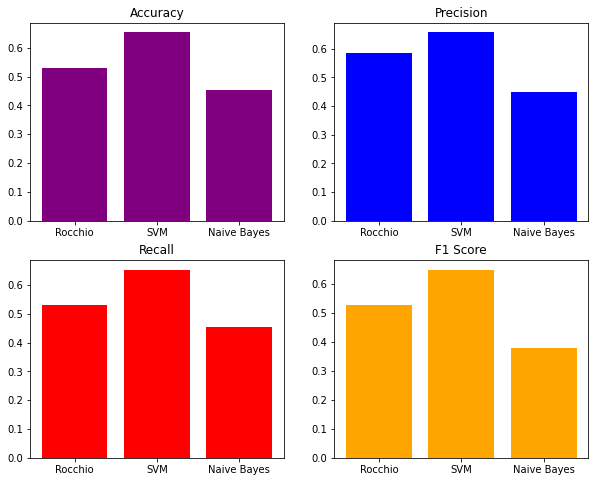

In [256]:
# TODO: Plot evaulations

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].set_title('Accuracy')
axes[0, 0].bar(model_names, accuracy_values, color='purple')

axes[0, 1].set_title('Precision')
axes[0, 1].bar(model_names, precision_values, color='blue')

axes[1, 0].set_title('Recall')
axes[1, 0].bar(model_names, recall_values, color='red')

axes[1, 1].set_title('F1 Score')
axes[1, 1].bar(model_names, f1_values, color='orange')

plt.show()

<div dir="rtl">
کدام مدل از همه دقیق‌تر عمل کرد؟ نتیجه‌گیری و تحلیل خود از نتایج ارزیابی را گزارش دهید.
</div>

<span style="color: #87CEEB; font-size: 16px;">SVM did the best then Rocchio and then Naive Bayes. SVM is strong since it can handle complexity, high-dimensional spaces and large number number of features. Despite other two methods, SVM is a non-linear classifiertending to e maximize the margin between the classes. Other two methods are linear separators although Rocchio can have somehow non-linear boundries to (while it's linear when you see locally). Also for some reasons like feature independence assumption, maybe specific data distribution/ characteristics, etc. Naive Bayes did a little worse than Rocchio.</span>


<div dir="rtl">
<h1>3. 
کاهش ابعاد و خوشه‌بندی متن
</h1>
</div>

<div dir="rtl">
<h2>3-1. 
کاهش ابعاد
</h2>
</div>

<div dir="rtl">
<h3>3-1-1. 
PCA
</h3>
یکی از روش‌های کاهش ابعاد، PCA است. با استفاده از پیاده‌سازی آن در کتابخانه sklearn، ابعاد ویژگی‌های X را کاهش دهید.
<br>
سپس با استفاده از explained_variance_ratio_ در الگوریتم PCA  نشان دهید که با وجود یک ترشولد 90 درصد تا چه میزان میتوان ابعاد ویژگی ها را کم تر کرد.
</div>

In [257]:
from sklearn.decomposition import PCA

def reduce_dimension(embeddings, n_components):
    """
    Performs dimensional reduction using PCA with n components left behind

    Parameters
    ----------
    embeddings : List
        A list of embeddings of documents
    
    n_components: int
        Number of components to keep

    Returns a list of reduced embeddings
    """

    X = np.array(embeddings)
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(X)
    reduced_embeddings_list = reduced_embeddings.tolist()

    return reduced_embeddings_list

<div dir="rtl">
در این قسمت می‌توانید برای شهود بهتر، نمودار رسم کنید و همچنین برای ساده‌تر شدن کار، از pipeline‌های sklearn بهره ببرید. 
<br>
<i> انجام این کار‌ها صرفا توصیه است و اجباری نیست. </i>
</div>

the most reduced dimension which has 90% cutoff explained variance: (dimention_size, captured_variance)
(18, 0.9024199792530407)


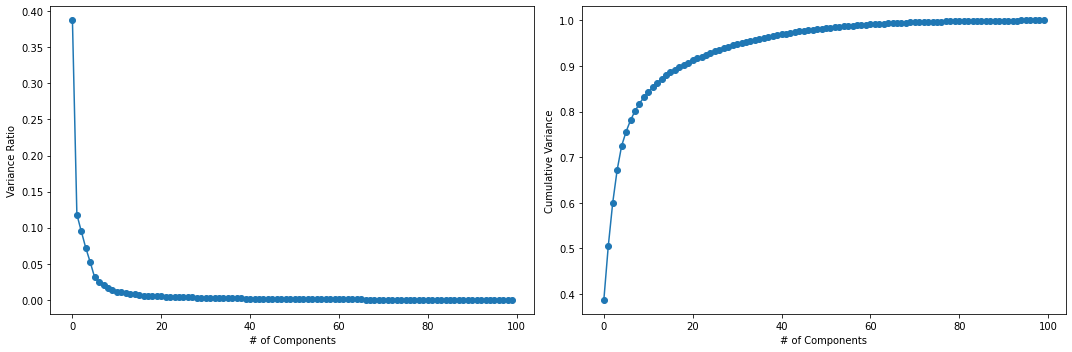

In [258]:
# TODO: Findout the most reduced dimension which has 90% cutoff explained variance. 
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

def plot_explained_variance(embeddings):
    """
    Plots the explained variance ratio and cumulative explained variance for different
    numbers of components using PCA.

    Parameters
    ----------
    embeddings : List
        A list of embeddings of documents
    """
    
    X = np.array(embeddings)
    pca_pipe = Pipeline([('pca', PCA())])

    pca_pipe.fit(X)
    explained_variance_ratio = pca_pipe.named_steps['pca'].explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    print('the most reduced dimension which has 90% cutoff explained variance: (dimention_size, captured_variance)')
    print([(i, cum_var) for i, cum_var in enumerate(cumulative_explained_variance) if cum_var>0.9][0])

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(explained_variance_ratio, marker='o')
    plt.xlabel('# of Components')
    plt.ylabel('Variance Ratio')

    plt.subplot(1, 2, 2)
    plt.plot(cumulative_explained_variance, marker='o')
    plt.xlabel('# of Components')
    plt.ylabel('Cumulative Variance')
    plt.tight_layout()
    plt.show()

plot_explained_variance(document_embeddings)    

<div dir="rtl">
<h3>3-1-2. 
TSNE
</h3>
<br>
     برای اینکه بتوانید در مراحل بعدی، نتایج خوشه‌بندی را مشاهده کنید، در این قسمت به پیاده‌سازی تابع کاهش بعد بردارهای جاسازی با استفاده از روش T-SNE می‌پردازید.
برای اینکار تابع convert_to_2d_tsne را پیاده‌سازی می‌کنید که لیستی از بردارهای جاسازی را به عنوان ورودی دریافت می‌کند و در خروجی، لیستی از بردارهای جاسازی کاهش بعد داده شده به دو بعد را تولید می‌کند. برای پیاده سازی این تابع می‌توانید از کتابخانه‌های آماده استفاده کنید.
<br>
توجه کنید که از بردارهای خروجی این قسمت <u>صرفا برای رسم نمودار</u> استفاده می‌کنید و تمامی مراحلی که در ادامه طی می‌کنید (به جز رسم نمودار)، باید با استفاده از بردارهای کاهش بعد داده <u>نشده</u> انجام شوند.
</div>


In [259]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from sklearn.manifold import TSNE

def convert_to_2d_tsne(emb_vecs, labels):
    tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=1000, random_state=23)
    emb_vectors_2d = tsne.fit_transform(emb_vecs)
    df_2d = pd.DataFrame(emb_vectors_2d, columns=['X1', 'X2'])
    df_2d['Y'] = labels
    return df_2d

    # to return a list not a df:
    # tsne = TSNE(n_components=2)
    # emb_vectors_2d = tsne.fit_transform(emb_vecs)
    # return emb_vectors_2d

def plot_2d_points(df_2d):
    plt.figure(figsize=(8, 6))
    for label in df_2d['Y'].unique():
        label_data = df_2d[df_2d['Y'] == label]
        plt.scatter(label_data['X1'], label_data['X2'], label=label, alpha=0.7)

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.show()

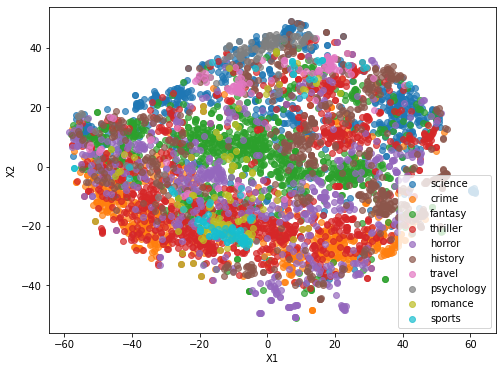

In [260]:
emb_vecs = df['X'].tolist()
labels = df['genre'].tolist()
df_2d = convert_to_2d_tsne(np.array(emb_vecs), labels)
plot_2d_points(df_2d)

<div dir="rtl">
<h2>3-2. 
خوشه‌بندی
</h2>
</div>

<div dir="rtl">
<h3>3-2-1. 
K-Means
</h3>

<div dir="rtl">
در این قسمت، شما ابتدا الگوریتم خوشه‌بندی K-means را 
<u><b>از پایه</b></u>
 پیاده‌سازی می‌کنید.

</div>

In [261]:
from typing import List
import random

def cluster_kmeans(emb_vecs, n_clusters):
    """
    Clusters input vectors using K-means method

    Parameters
    ----------
    emb_vecs : List
        A list of vectors
    
    n_clusters: int
        Number of clusters

    Returns
    -------
    list
        Two lists: 1) A list containing cluster centers 2) A list containing cluster index for each input vector
    """
    emb_matrix = np.array(emb_vecs)

    initial_centroids_indexes = random.sample(range(len(emb_vecs)), n_clusters)
    initial_centroids = emb_matrix[initial_centroids_indexes]

    for _ in range(10): 
        distances = np.linalg.norm(emb_matrix[:, np.newaxis] - initial_centroids, axis=2)
        cluster_indices = np.argmin(distances, axis=1)
        initial_centroids = np.array([emb_matrix[cluster_indices == i].mean(axis=0) for i in range(n_clusters)])

    return initial_centroids.tolist(), cluster_indices.tolist()

<div dir="rtl">
 با استفاده از K-Means خوشه‌های اسناد را ایجاد کنید. الگوریتم را با استفاده از چند مقدار مختلف تعداد خوشه‌ها (k) اجرا کنید. در هربار اجرا، با استفاده از تعدادی از اسناد موجود در هر خوشه، موضوع آن خوشه را تعیین کرده و خوشه‌بندی حاصله را با استفاده از بردار‌های دوبعدی قسمت قبل، رسم کنید. با اینکار، پیاده‌سازی خود و همچنین کارایی این الگوریتم در خوشه‌بندی اسناد و قرار دادن اسناد مشابه در خوشه‌های یکسان را بررسی کنید.
<br>
 نمودار silhouette score برای مقدار‌های مختلف k را رسم کرده و silhouette analysis برای انتخاب k مناسب انجام دهید. 
 همچنین با استفاده از داده‌های دارای برچسب، مقدار purity به ازای k را رسم کرده و مقدار purity برای k نهایی را گزارش کنید.
<br>
</div>

In [262]:
from collections import Counter

def purity_score(y_true, y_pred):
    """
    Calculate the purity score for the given cluster assignments and ground truth classes
    
    y_true: list
        ground truth labels for each document
    
    y_pred: list
        predicted labels for each document
        
    Returns a purity score between 0.0 and 1.0 (higher is better)
    """
    contingency_table = Counter(zip(y_true, y_pred))
    
    #Note that there was a difference between purity calculation in slides VS book & other resources that I searched. In slides, it also 
    # averaged each cluster according to its size but in book, it just summed up the max values in each cluster. I used the book here
    purity = 0.0
    for pred_class in set(y_pred):
        max_count_in_cluster = max(contingency_table[(true_class, pred_class)] for true_class in set(y_true))
        purity += max_count_in_cluster
    
    purity /= len(y_true)
    
    return purity

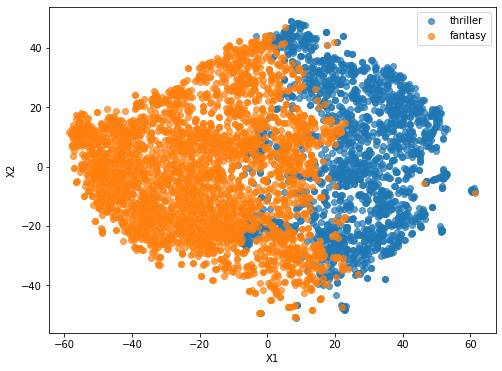

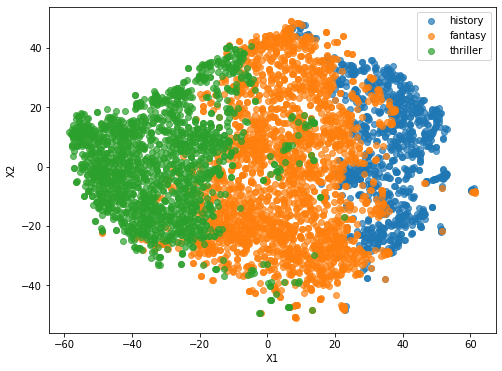

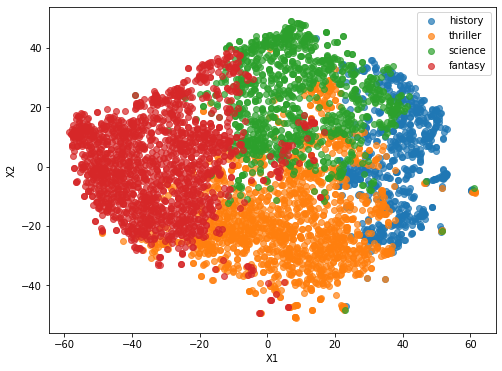

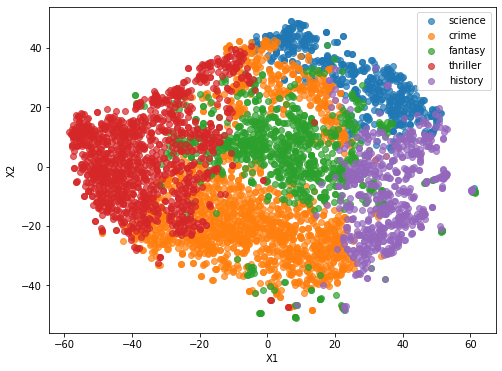

In [263]:
from collections import Counter

k_values = [2, 3, 4, 5]
y_true = df['Y'].tolist()
num_to_genre_mapping = {v: k for k, v in genre_mapping.items()}

for k in k_values:
    y_pred = cluster_kmeans(document_embeddings, k)[1]
    contingency_table = Counter(zip(y_true, y_pred))
    cluster_topics = {}

    for pred_class in set(y_pred):
        cluster_labels = set()
        for true_class in set(y_true):
            count = contingency_table[(true_class, pred_class)]
            cluster_labels.add((true_class, count))
        sorted_labels_tuple = sorted(cluster_labels, key=lambda x: x[1], reverse=True)
        sorted_labels = [t[0] for t in sorted_labels_tuple]
        for label in sorted_labels:
            if label not in cluster_topics.values():
                cluster_topics[pred_class] = label
                break
            else:
                pass

    topics = [cluster_topics[l] for l in y_pred]
    topic_names = [num_to_genre_mapping[t] for t in topics]
    df_2d = convert_to_2d_tsne(np.array(document_embeddings), topic_names)
    plot_2d_points(df_2d)

In [264]:
# TODO: Calculate silhouette score and purity score

from sklearn.metrics import silhouette_score

silhouette_scores = []
purity_scores = []
k_values = list(range(2, 16))
for k in k_values:
    cluster_labels = cluster_kmeans(document_embeddings, k)[1]
    silhouette_scores.append(silhouette_score(document_embeddings, cluster_labels))
    purity_scores.append(purity_score(y_true, cluster_labels))

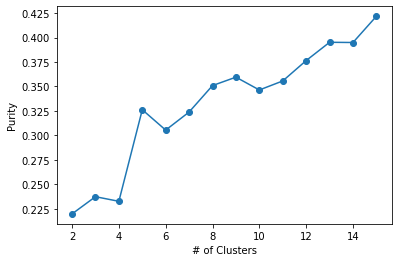

In [265]:
#TODO: plot purity for different value of k (at least 5 different k values)

plt.plot(k_values, purity_scores, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Purity')
plt.show()

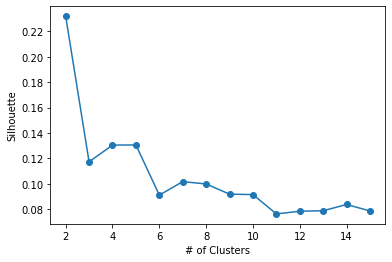

In [283]:
#TODO: plot silhouette for different value of k (at least 5 different k values)

plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Silhouette')
plt.show()

In [284]:
print(f"purity for 2 number of clusters is: {purity_scores[0]}")
print(f"purity for 3 number of clusters is: {purity_scores[1]}")
print(f"purity for 4 number of clusters is: {purity_scores[2]}")
print(f"purity for 5 number of clusters is: {purity_scores[3]}")

purity for 2 number of clusters is: 0.21966931500966289
purity for 3 number of clusters is: 0.23727721709254884
purity for 4 number of clusters is: 0.23255314580201847
purity for 5 number of clusters is: 0.32617564955980244


<div dir="rtl">
با استفاده از نمودارهای رسم شده توضیح دهید بهترین k برای انتخاب در داده ما با استفاده از الگوریتم K-Means چیست؟
چرا؟
</div>

<span style="color: #87CEEB; font-size: 16px;">The best value for k according to Silhouette plot is 2 and then 4 or 5 because data was so much unordered made it hard to cluster in a way that in each cluster becomes distinct from other clusters. Also when we look at the purity plot, we can see it's an ascending function in terms of the number of clusters. It makes sense. According to class slides, high purity is easy to achieve when the number of clusters is large. In particular, purity is 1 if each point gets its own cluster. Thus we can not use purity to trade off the quality if the clustering against the number of clusters. Anyway, clustering for the 2, 4 and 5 number of clusters, is plotted before and the corresponding values of purity are printed</span>


<div dir="rtl">
<h3>3-2-2. 
Hierarchical clustering
</h3>
</div>

<div dir="rtl">
تکنیک خوشه‌بندی سلسله مراتبی یکی از تکنیک‌های خوشه‌بندی در یادگیری ماشین است. در این قسمت شما می‌توانید از لایببری scipy یا هر لایبرری دیگری در پایتون استفاده کنید تا داده‌ها را به صورت سلسله‌مراتبی خوشه‌بندی کنید. سپس می‌توانید خوشه‌ها را با matplotlib مشاهده کنید.
</div>

In [268]:
# TODO: Perform hierarchical clustering on X
from scipy.cluster.hierarchy import dendrogram, linkage

linkage = linkage(document_embeddings, method='ward')

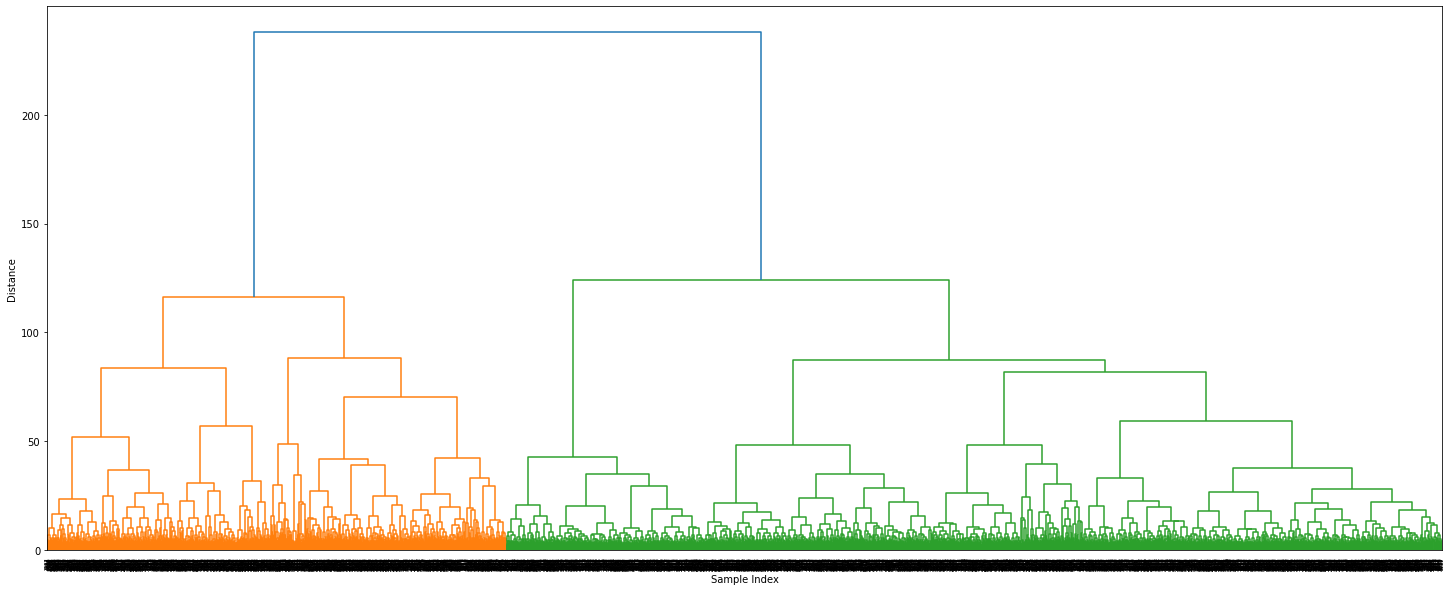

In [269]:
# TODO: Plot dendrogram

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()